# 1D GAN

Inspirado por postagem do Jason Brownlee: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tqdm import tqdm
import tensorflow_addons as tfa
from IPython import display

In [2]:
@tf.function
def f(x):
    # return x*x
    return x*x*x+10*x*x-20
    # return tf.math.sin(x)

## With Keras

In [3]:
discriminator = keras.Sequential([
    layers.Dense(25, activation="relu", input_dim=2, kernel_initializer="he_uniform", name="discriminator_dense_1"),
    layers.Dense(75, activation="relu", input_dim=2, kernel_initializer="he_uniform", name="discriminator_dense_2"),
    layers.Dense(1, activation="sigmoid", name="discriminator_dense_3")
], name="discriminator")

discriminator.summary()
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_dense_1 (Dens  (None, 25)               75        
 e)                                                              
                                                                 
 discriminator_dense_2 (Dens  (None, 75)               1950      
 e)                                                              
                                                                 
 discriminator_dense_3 (Dens  (None, 1)                76        
 e)                                                              
                                                                 
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


In [4]:
generator = keras.Sequential([
    layers.Dense(25, input_dim=5, activation="relu", kernel_initializer="he_uniform", name="generator_dense_1"),
    layers.Dense(70, activation="relu", kernel_initializer="he_uniform", name="generator_dense_2"),
    layers.Dense(50, activation="relu", kernel_initializer="he_uniform", name="generator_dense_3"),
    layers.Dense(2, name="generator_dense_4")
], name="generator")

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_dense_1 (Dense)   (None, 25)                150       
                                                                 
 generator_dense_2 (Dense)   (None, 70)                1820      
                                                                 
 generator_dense_3 (Dense)   (None, 50)                3550      
                                                                 
 generator_dense_4 (Dense)   (None, 2)                 102       
                                                                 
Total params: 5,622
Trainable params: 5,622
Non-trainable params: 0
_________________________________________________________________


In [5]:
discriminator.trainable = False
gan_model = keras.Sequential([
    generator,
    discriminator
], name="gan_model")
gan_model.summary()
gan_model.compile(loss="binary_crossentropy", optimizer="adam")

Model: "gan_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 2)                 5622      
                                                                 
 discriminator (Sequential)  (None, 1)                 2101      
                                                                 
Total params: 7,723
Trainable params: 5,622
Non-trainable params: 2,101
_________________________________________________________________


In [6]:
def train(epochs=100, batch_size=128):
    half_batch = tf.cast(batch_size / 2, tf.int32)

    for epoch in range(epochs):
        # generate half batch of real samples
        x1_real = tf.random.uniform(shape=[half_batch], minval=-5.0, maxval=5.0)
        x2_real = f(x1_real)
        x_real = tf.stack([x1_real, x2_real], axis=-1)
        
        # generate half batch of fake samples
        fake_latent = tf.random.normal(shape=[half_batch, 5])
        x_fake = generator(fake_latent, training=True)
        
        # train discriminator
        discriminator.train_on_batch(x_real, tf.ones(shape=[half_batch, 1]))
        discriminator.train_on_batch(x_fake, tf.zeros(shape=[half_batch, 1]))
        
        # train generator
        gan_model.train_on_batch(fake_latent, tf.ones(shape=[half_batch, 1]))
        
        # evaluation
        if (epoch+1) % 100 == 0:
            summarize_performance(epoch)

In [7]:
x1_real = tf.random.uniform(shape=[100], minval=-5.0, maxval=5.0)
fake_latent = tf.random.normal(shape=[100, 5])

def summarize_performance(epoch):
    # evaluate the discriminator first
    x_real = tf.stack([x1_real, f(x1_real)], axis=-1)
    _, accuracy_real = discriminator.evaluate(x_real, tf.ones(shape=[100, 1]), verbose=0)
    
    x_fake = generator(fake_latent)
    _, accuracy_fake = discriminator.evaluate(x_fake, tf.zeros(shape=[100, 1]), verbose=0)
    
    display.clear_output(wait=True)
    print(f"Epoch {epoch+1}: discrim. accuracy for real: {accuracy_real}, for fake: {accuracy_fake}")
    
    # scatter plot real and fake data points
    plt.scatter(x_real[:, 0], x_real[:, 1], color="red")
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color="blue")
    plt.show()

Epoch 4000: discrim. accuracy for real: 0.800000011920929, for fake: 0.3799999952316284


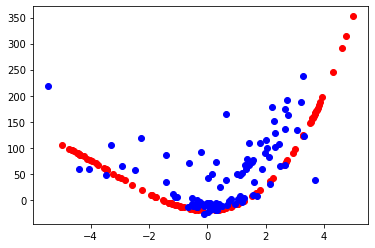

In [8]:
train(4000)

Accuracy for real: 0.800000011920929, for fake: 0.3400000035762787


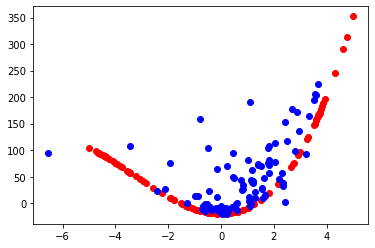

In [9]:
def test_generator():
    fake_latent = tf.random.normal(shape=[100, 5])
    x_real = tf.stack([x1_real, f(x1_real)], axis=-1)
    _, accuracy_real = discriminator.evaluate(x_real, tf.ones(shape=[100, 1]), verbose=0)

    x_fake = generator(fake_latent)
    _, accuracy_fake = discriminator.evaluate(x_fake, tf.zeros(shape=[100, 1]), verbose=0)

    print(f"Accuracy for real: {accuracy_real}, for fake: {accuracy_fake}")

    # scatter plot real and fake data points
    plt.scatter(x_real[:, 0], x_real[:, 1], color="red")
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color="blue")
    plt.show()
    
test_generator()

## With Custom Training Loop

In [10]:
def create_discriminator_ctl():
    return keras.Sequential([
        layers.Dense(25, activation="relu", input_dim=2, kernel_initializer="he_uniform", name="discriminator_dense_1_ctl"),
        layers.Dense(75, activation="relu", input_dim=2, kernel_initializer="he_uniform", name="discriminator_dense_2_ctl"),
        layers.Dense(1, activation="sigmoid", name="discriminator_dense_3_ctl")
    ], name="discriminator_custom_ctl")

In [11]:
def create_generator_ctl():
    return keras.Sequential([
    layers.Dense(25, input_dim=5, activation="relu", kernel_initializer="he_uniform", name="generator_dense_1_ctl"),
    layers.Dense(70, activation="relu", kernel_initializer="he_uniform", name="generator_dense_2_ctl"),
    layers.Dense(50, activation="relu", kernel_initializer="he_uniform", name="generator_dense_3_ctl"),
    layers.Dense(2, name="generator_dense_4_ctl")
], name="generator_custom_ctl")

In [12]:
loss_function = keras.losses.BinaryCrossentropy()
optimizer_generator = keras.optimizers.Adam(learning_rate=0.001)
optimizer_discriminator = keras.optimizers.Adam()

In [13]:
@tf.function
def train_step(g, d, x_real, fake_latent, batch_size):    
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        x_fake = g(fake_latent, training=True)
        
        discriminated_real = d(x_real, training=True)
        discriminated_fake = d(x_fake, training=True)
        
        generator_loss = loss_function(tf.ones(shape=[batch_size, 1]), discriminated_fake)
        discriminator_loss = loss_function(tf.ones(shape=[batch_size, 1]), discriminated_real) + loss_function(tf.zeros(shape=[batch_size, 1]), discriminated_fake)
    
    generator_gradients = gen_tape.gradient(generator_loss, g.trainable_variables)
    discriminator_gradients = disc_tape.gradient(discriminator_loss, d.trainable_variables)
    
    optimizer_generator.apply_gradients(zip(generator_gradients, g.trainable_variables))
    optimizer_discriminator.apply_gradients(zip(discriminator_gradients, d.trainable_variables))
    

def train_custom_loop(g, d, epochs=100, batch_size=128):
    for epoch in range(epochs):
        # generate batch of real samples
        x1_real = tf.random.uniform(shape=[batch_size], minval=-5.0, maxval=5.0)
        x2_real = f(x1_real)
        x_real = tf.stack([x1_real, x2_real], axis=-1)

        # generate batch of fake samples
        fake_latent = tf.random.normal(shape=[batch_size, 5])

        train_step(g, d, x_real, fake_latent, batch_size)
        
        # evaluation
        if (epoch+1) % 100 == 0:
            summarize_performance_ctl(g, epoch)

In [14]:
x1_real = tf.random.uniform(shape=[100], minval=-5.0, maxval=5.0)
fake_latent = tf.random.normal(shape=[100, 5])

def summarize_performance_ctl(g, epoch, fixed_window=True):
    x_real = tf.stack([x1_real, f(x1_real)], axis=-1)
    x_fake = g(fake_latent)
    
    display.clear_output(wait=True)
    print(f"Epoch {epoch+1}:")
    
    # scatter plot real and fake data points
    if fixed_window:
        plt.xlim((-6., 6.))
        plt.ylim((-1.5, 1.5))
    plt.scatter(x_real[:, 0], x_real[:, 1], color="red")
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color="blue")
    plt.show()

Epoch 4000:


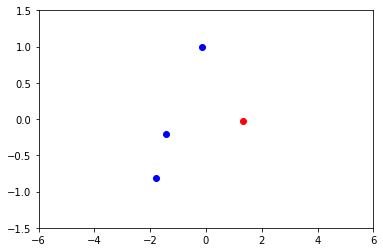

In [15]:
discriminator_ctl = create_discriminator_ctl()
generator_ctl = create_generator_ctl()

train_custom_loop(generator_ctl, discriminator_ctl, 4000, 128)

## CTL with Wasserstein Loss

In [16]:
def create_critic_wass():
    return keras.Sequential([
        layers.Dense(25, activation="relu", input_dim=2, kernel_initializer="he_uniform", name="critic_dense_1_wass"),
        layers.Dense(75, activation="relu", kernel_initializer="he_uniform", name="critic_dense_2_wass"),
        layers.Dense(125, activation="relu", kernel_initializer="he_uniform", name="critic_dense_3_wass"),
        layers.Dense(1, activation="linear", name="critic_dense_4_wass")
    ], name="critic_wass")

In [17]:
def create_generator_wass():
    return keras.Sequential([
        layers.Dense(25, input_dim=5, activation="relu", kernel_initializer="he_uniform", name="generator_dense_1_wass"),
        layers.Dense(70, activation="relu", kernel_initializer="he_uniform", name="generator_dense_2_wass"),
        layers.Dense(50, activation="relu", kernel_initializer="he_uniform", name="generator_dense_3_wass"),
        layers.Dense(2, activation="linear", name="generator_dense_4_wass")
], name="generator_wass")

In [18]:
@tf.function
def train_step_critic_wass(g, c, batch_size):  
    # generate batch of real samples
    x1_real = tf.random.uniform(shape=[batch_size], minval=-5.0, maxval=5.0)
    x2_real = f(x1_real)
    x_real = tf.stack([x1_real, x2_real], axis=-1)

    # generate batch of fake samples
    fake_latent = tf.random.normal(shape=[batch_size, 5])

    # gradient penalty for W Loss
    gp_epsilon = tf.random.uniform(shape=[batch_size, 1])
    with tf.GradientTape(persistent=True) as critic_tape:
        with tf.GradientTape() as gp_tape:
            x_fake = g(fake_latent, training=True)
            x_fake_mixed = gp_epsilon * x_real + (1 - gp_epsilon) * x_fake
            x_fake_mixed_predicted = c(x_fake_mixed, training=True)
            
            # computing the gradient penalty
            gp_grads = gp_tape.gradient(x_fake_mixed_predicted, x_fake_mixed)
            gp_grad_norms = tf.sqrt(tf.reduce_sum(tf.square(gp_grads), axis=[1]))
            gradient_penalty = tf.reduce_mean(tf.square(gp_grad_norms - 1))

        criticized_real = c(x_real, training=True)
        criticized_fake = c(x_fake, training=True)
        
        loss_real = tf.reduce_mean(criticized_real)
        loss_fake = tf.reduce_mean(criticized_fake)
        loss_gp = 10. * gradient_penalty
        critic_loss = loss_fake - loss_real + loss_gp
        # tf.print("loss_real:", loss_real, "loss_fake:", loss_fake, "loss_gp:", loss_gp)
        # tf.print("critic_loss", critic_loss)
    
    critic_gradients = critic_tape.gradient(critic_loss, c.trainable_variables)    
    optimizer_critic_wass.apply_gradients(zip(critic_gradients, c.trainable_variables))
    
    
@tf.function
def train_step_generator_wass(g, c, batch_size):
    fake_latent = tf.random.normal(shape=[batch_size, 5])

    with tf.GradientTape() as gen_tape:
        x_fake = g(fake_latent, training=True)
        criticized_fake = c(x_fake, training=True)
        loss_fake = tf.reduce_mean(criticized_fake)
        generator_loss = -loss_fake

    # tf.print("generator_loss", generator_loss)
    generator_gradients = gen_tape.gradient(generator_loss, g.trainable_variables)
    optimizer_generator_wass.apply_gradients(zip(generator_gradients, g.trainable_variables))

    
def train_custom_loop_wass(g, c, epochs=100, batch_size=128, n_critic=5):
    for epoch in tqdm(range(epochs)):
        for i in range(n_critic):
            train_step_critic_wass(g, c, batch_size)

        train_step_generator_wass(g, c, batch_size)
        
        # evaluation
        if (epoch+1) % 100 == 0:
            summarize_performance_wass(g, epoch, False)



In [19]:
x1_real = tf.random.uniform(shape=[100], minval=-5.0, maxval=5.0)
fake_latent = tf.random.normal(shape=[100, 5])

def summarize_performance_wass(g, epoch, fixed_window=True):
    x_real = tf.stack([x1_real, f(x1_real)], axis=-1)
    x_fake = g(fake_latent)
    
    display.clear_output(wait=True)
    print(f"Epoch {epoch+1}:")
    
    # scatter plot real and fake data points
    if fixed_window:
        plt.xlim((-6., 6.))
        plt.ylim((-1.5, 1.5))
    plt.scatter(x_real[:, 0], x_real[:, 1], color="red")
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color="blue")
    plt.show()

Epoch 10000:


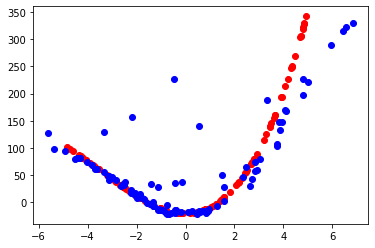

100%|██████████| 10000/10000 [04:24<00:00, 37.78it/s]


In [20]:
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=1000,
    decay_rate=0.75)
optimizer_generator_wass = keras.optimizers.Adam(lr_scheduler, beta_1=0.5)
optimizer_critic_wass = keras.optimizers.Adam(0.0005, beta_1=0.5)

critic_wass = create_critic_wass()
generator_wass = create_generator_wass()

train_custom_loop_wass(generator_wass, critic_wass, 10000, 128, n_critic=5)